**Feature Distribution**

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


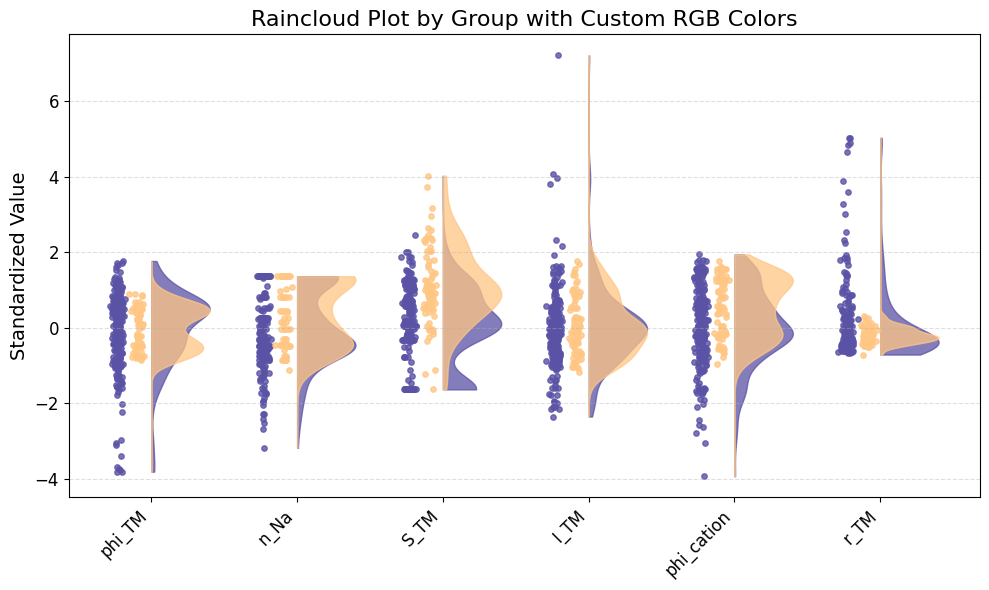

In [1]:
# Install 'joblib' library quietly (often used for saving/loading scikit-learn objects)
!pip install joblib -q

# Download the pre-trained scaler object from a GitHub release quietly
!wget -q https://github.com/LIANGTING-WU/ML_Phase_Predictor/releases/download/v1.0/scaler.pkl -O scaler.pkl

import pandas as pd
import numpy as np
import pickle
import joblib  # Used for loading the scaler
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde # For the "cloud" plot

# 1. Load data and scaler
# Load the full dataset from the GitHub repository URL
df = pd.read_csv("https://raw.githubusercontent.com/LIANGTING-WU/ML_Phase_Predictor/main/Full-Dataset-350.csv")
# Load the previously downloaded (and fitted) scaler object
scaler = joblib.load('scaler.pkl')

# 2. Define column orders
# 'train_order' is the original feature order the scaler was fitted on
train_order   = ["n_Na", "r_TM", "I_TM", "phi_TM", "S_TM", "phi_cation"]
# 'desired_order' is the order we want to display the features on the plot
desired_order = ["phi_TM", "n_Na", "S_TM", "I_TM", "phi_cation", "r_TM"]

# 3. Standardize data and add group column
# Apply the scaler to the data using the original 'train_order'
scaled = scaler.transform(df[train_order])
# Create a new DataFrame with the scaled data
# Then, reorder the columns according to 'desired_order'
df_std = pd.DataFrame(scaled, columns=train_order)[desired_order]
# Add the 'Group' column (e.g., "Train", "Test") from the original df to the scaled df
df_std['Group'] = df['Group']

# 4. Define specific RGB colors for groups
# Create a dictionary mapping group names to their specific RGB color tuples (normalized 0-1)
group_colors = {
    "Train": (90/255, 82/255, 165/255),  # Corresponds to original 'group 0'
    "Test": (255/255, 198/255, 132/255) # Corresponds to original 'group 1'
}

# 5. Define plot parameters
# Set the main x-axis positions for each feature (0, 1, 2, ...)
positions = np.arange(len(desired_order))
# Set the maximum width for the "cloud" (KDE plot)
cloud_max_width = 0.4
# Calculate the base center position for the "rain" (scatter plot) part
rain_center = positions - cloud_max_width - 0.05
# Define horizontal offsets for the "rain" (scatter) points for each group
# This ensures "Train" and "Test" points are slightly separated horizontally
group_offsets = {"Train": -0.07, "Test": +0.07}

# 6. Create the raincloud plot
fig, ax = plt.subplots(figsize=(10, 6))

# Loop through each feature (variable) and its corresponding x-position
for idx, (pos, var) in enumerate(zip(positions, desired_order)):
    # Create a y-axis range (linspace) for calculating the KDE
    ys = np.linspace(df_std[var].min(), df_std[var].max(), 200)

    # Draw the "cloud" (KDE) and "rain" (scatter) for each group
    for grp_name in ["Train", "Test"]:
        # Filter the data to get values for the current feature and current group
        vals = df_std[df_std['Group'] == grp_name][var].values

        # KDE calculation requires at least 2 data points
        if len(vals) < 2:
            continue

        # Calculate the Kernel Density Estimation (KDE)
        kde = gaussian_kde(vals)
        # Evaluate the KDE at the y-axis points
        dens = kde(ys)
        # Normalize the density and scale it by the max width to get the "cloud" shape
        widths = dens / dens.max() * cloud_max_width
        # Get the color for the current group
        color = group_colors[grp_name]

        # Draw the "Cloud" (half-violin plot)
        ax.fill_betweenx(ys, pos, pos + widths, color=color, alpha=0.75)

        # Draw the "Rain" (jittered scatter plot)
        # Calculate the center for the jitter plot, applying the group-specific offset
        center = rain_center[idx] + group_offsets[grp_name] + 0.29
        # Create the jittered x-positions (a small normal distribution around the center)
        x_j = np.random.normal(loc=center, scale=0.02, size=len(vals))
        # Plot the individual data points (the "rain")
        ax.scatter(x_j, vals, alpha=0.8, s=15, color=color)

# 7. Final plot formatting
# Set the main x-ticks to the feature positions
ax.set_xticks(positions)
# Set the x-tick labels to the feature names, rotating them for readability
ax.set_xticklabels(desired_order, rotation=45, ha='right', fontsize=12)
# Set y-axis label
ax.set_ylabel("Standardized Value", fontsize=14)
# Set y-tick label size
ax.tick_params(axis='y', labelsize=12)
# Set plot title
ax.set_title("Raincloud Plot by Group with Custom RGB Colors", fontsize=16)
# Add a light horizontal grid
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Adjust layout to prevent labels from overlapping
plt.tight_layout()
# Save the figure as a high-resolution PNG
#plt.savefig("raincloud_custom_colors.png", dpi=600)
# Display the plot
plt.show()

**Principal Component Analysis**

Using DataFrame 'df' loaded from the previous cell...
All required columns found. Starting data preprocessing...
Found 270 'Train' data points (expected 270)
Found 80 'Test' data points (expected 80)
Data preparation complete.
Standardizing the data...
Standardization complete.
Running PCA analysis...
PCA complete.
PC1 (Principal Component 1) explains 49.22% of variance
PC2 (Principal Component 2) explains 27.89% of variance
Total variance explained: 77.11%
Preparing data for plotting...
Plotting data is ready. Generating plot...


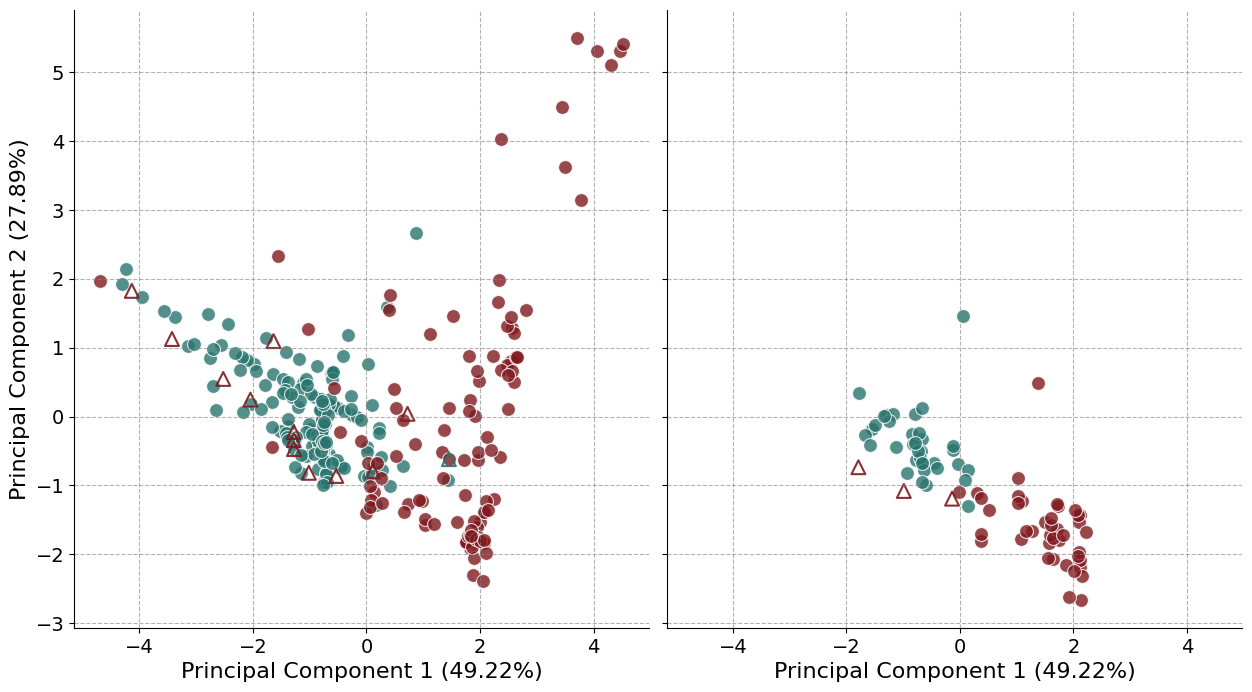

In [5]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Check if the DataFrame 'df' from the previous cell (Raincloud plot) exists
if 'df' in locals():
    print(f"Using DataFrame 'df' loaded from the previous cell...")
    # Create a copy to avoid modifying the original DataFrame
    data = df.copy()

    # --- Define required column names for analysis ---
    # 1. Feature columns for PCA (from your training code)
    x_features = ["n_Na", "r_TM", "I_TM", "phi_TM", "S_TM", "phi_cation"]

    # 2. Label columns for grouping, color, and shape
    group_col = "Group"      # "Train" or "Test"
    exp_col = "Phase_EXP"    # Experimental true phase (0 or 1)
    dnn_col = "Phase_DNN"    # DNN predicted phase (0 or 1)
    # --- Column definitions end ---

    # Check if all required columns exist in the DataFrame
    required_cols = x_features + [group_col, exp_col, dnn_col]
    missing_cols = [col for col in required_cols if col not in data.columns]

    if missing_cols:
        print(f"Error: The CSV (DataFrame 'df') is missing necessary columns: {missing_cols}")
    else:
        print("All required columns found. Starting data preprocessing...")

        # --- Create new labels based on your requirements ---

        # 1. Create "Phase Label" (for color)
        # =0 -> 'P2'; =1 -> 'O3'
        data['Phase Label'] = np.where(data[exp_col] == 0, 'P2', 'O3')

        # 2. Create "Classification" (for scatter plot markers)
        # If Phase_DNN == Phase_EXP, it's "Correct", otherwise "Misclassified"
        data['Classification'] = np.where(data[exp_col] == data[dnn_col],
                                          'Correct', 'Misclassified')

        # --- Separate data based on the "Group" column ---
        df_train = data[data[group_col] == "Train"].copy()
        df_test = data[data[group_col] == "Test"].copy()

        print(f"Found {len(df_train)} 'Train' data points (expected 270)")
        print(f"Found {len(df_test)} 'Test' data points (expected 80)")

        # Extract features (X)
        x_train_raw = df_train[x_features].values
        x_test_raw = df_test[x_features].values

        print("Data preparation complete.")

        # --- Data Standardization ---
        print("Standardizing the data...")

        # 1. Initialize the Scaler
        scaler = StandardScaler()

        # 2. Fit the scaler *only* on the training data
        scaler.fit(x_train_raw)

        # 3. Transform both training and test data
        x_train_scaled = scaler.transform(x_train_raw)
        x_test_scaled = scaler.transform(x_test_raw)

        print("Standardization complete.")

        # --- Perform PCA Analysis ---
        print("Running PCA analysis...")

        # 1. Initialize PCA to 2 components
        pca = PCA(n_components=2)

        # 2. Fit PCA *only* on the scaled training data
        pca.fit(x_train_scaled)

        # 3. Transform both datasets into the 2D PCA space
        x_train_pca = pca.transform(x_train_scaled)
        x_test_pca = pca.transform(x_test_scaled)

        # 4. Check the variance explained by each principal component
        variance = pca.explained_variance_ratio_
        print("PCA complete.")
        print(f"PC1 (Principal Component 1) explains {variance[0]*100:.2f}% of variance")
        print(f"PC2 (Principal Component 2) explains {variance[1]*100:.2f}% of variance")
        print(f"Total variance explained: {(variance.sum())*100:.2f}%")

        # --- Prepare data for plotting ---
        print("Preparing data for plotting...")

        # Create DataFrames for the PCA results
        df_pca_train = pd.DataFrame(x_train_pca, columns=["PC1", "PC2"], index=df_train.index)
        df_pca_test = pd.DataFrame(x_test_pca, columns=["PC1", "PC2"], index=df_test.index)

        # Combine PCA results and metadata
        df_pca_all = pd.concat([df_pca_train, df_pca_test])
        df_metadata = data[[group_col, 'Phase Label', 'Classification']]
        df_plot_data = df_pca_all.join(df_metadata)

        print("Plotting data is ready. Generating plot...")

        # --- Use FacetGrid for manual plotting ---

        # Use the specified custom colors
        custom_palette = {"P2": "#29746E", "O3": "#7F191E"}

        # 1. Set up the FacetGrid
        g = sns.FacetGrid(
            data=df_plot_data,
            col=group_col,       # Create columns for "Train" and "Test"
            hue="Phase Label",   # Color points by "Phase Label" (P2/O3)
            palette=custom_palette,
            height=7,
            aspect=0.9
        )

        # 2. Map "Correct" classifications (solid circles)
        g.map_dataframe(
            lambda data, **kws: sns.scatterplot(
                data=data[data['Classification'] == 'Correct'],
                x="PC1",
                y="PC2",
                marker="o",      # Solid circle
                s=100,
                alpha=0.8,
                legend=False,
                **kws
            )
        )

        # 3. Map "Misclassified" (hollow triangles)
        # We need a custom function to plot hollow markers
        def plot_hollow_triangles(data, **kws):
            color = kws.get('color') # Get the color from the 'hue'
            misclassified_data = data[data['Classification'] == 'Misclassified']

            if not misclassified_data.empty:
                plt.scatter(
                    misclassified_data['PC1'],
                    misclassified_data['PC2'],
                    marker='^',        # Triangle marker
                    s=100,
                    alpha=0.9,
                    facecolors='none', # Hollow
                    edgecolors=color,  # Use the hue color for the edge
                    linewidth=1.5
                )

        g.map_dataframe(plot_hollow_triangles)

        # 4. Add a "gray" grid to each subplot
        g.map(plt.grid, linestyle='--', alpha=0.6, color='gray')

        # 5. Set plot titles and labels
        pc1_label = f"Principal Component 1 ({variance[0]*100:.2f}%)"
        pc2_label = f"Principal Component 2 ({variance[1]*100:.2f}%)"

        g.set_axis_labels(pc1_label, pc2_label)
        g.set_titles("") # Remove default subplot titles ("Group = Train")

        # 6. Increase font size for labels and ticks
        g.tick_params(axis='both', which='major', labelsize=14)
        for ax in g.axes.flat:
            if ax.get_xlabel():
                ax.xaxis.label.set_size(16)
            if ax.get_ylabel():
                ax.yaxis.label.set_size(16)

        # 7. Adjust layout
        g.fig.tight_layout(pad=1.0)

        # 8. Save the figure and prepare for download
        file_save_name = 'PCA_Analysis_600dpi.png'

        #g.fig.savefig(
        #    file_save_name,
        #    dpi=600,
        #    bbox_inches='tight' # Ensure no extra white space is cut off
        #)

        # 9. Download the file from Google Colab
        #try:
        #    from google.colab import files
        #    files.download(file_save_name)
        #except Exception as e:
        #    print(f"Download failed: {e}. You can manually download {file_save_name} from the file panel on the left.")

        # 10. Show the plot
        plt.show()

else:
    print("Error: DataFrame 'df' was not found.")
    print("Please run the previous 'Raincloud plot' cell first to load the data.")